# __EXP#4__

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, random_split, DataLoader
from sklearn.metrics import mean_squared_error
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation
import matplotlib.pyplot as plt

In [ ]:
# predicted variable --- the Fame/Popularity of US presidents
# source: https://today.yougov.com/ratings/politics/popularity/US-presidents/all

In [23]:
# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, xpath, ypath='/content/drive/MyDrive/Colab_Data/presidents_impression.csv', y_name='Popularity'):
        # load the csv file as a dataframe
        dfx = pd.read_csv(xpath, index_col=0)
        dfy = pd.read_csv(ypath, index_col=0)
        # store the name of features
        self.features = dfx.columns
        # store the inputs and outputs
        self.X = dfx.values.astype('float32')
        self.y = dfy[y_name].values.astype('float32')
        # ensure target has the right shape
        self.y = self.y.reshape((len(self.y), 1))
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

In [24]:
# prepare the dataset
def prepare_data(path, p_test=0.2):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits(p_test)
    # prepare data loaders
    train_dl = DataLoader(train, shuffle=True)
    test_dl = DataLoader(test)
    return train_dl, test_dl

In [25]:
# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
    # enumerate epochs
    for epoch in range(200):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

In [26]:
# model definition
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = nn.Linear(n_inputs, 40)
        nn.init.xavier_uniform_(self.hidden1.weight)
        self.act1 = nn.Sigmoid()
        # second hidden layer
        self.hidden2 = nn.Linear(40, 20)
        nn.init.xavier_uniform_(self.hidden2.weight)
        self.act2 = nn.Sigmoid()
        # third hidden layer and output
        self.hidden3 = nn.Linear(20, 1)
        nn.init.xavier_uniform_(self.hidden3.weight)
 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        return X

In [27]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    return predictions, actuals

In [28]:
path = '/content/drive/MyDrive/Colab_Data/rank_bert_1.csv'
train_dl, test_dl = prepare_data(path, p_test=0)
print(len(train_dl.dataset), len(test_dl.dataset))

10 0


In [30]:
# initialize the model
model = MLP(124)
# train the model
train_model(train_dl, model)

In [31]:
# evaluate model performace
predictions, actuals = evaluate_model(train_dl, model)
# calculate mse
mse = mean_squared_error(actuals, predictions)
print('MSE: %.3f, RMSE: %.3f' % (mse, np.sqrt(mse)))

MSE: 0.008, RMSE: 0.089


In [32]:
# attribute interpretation
ig = IntegratedGradients(model)
ig_attr_test = ig.attribute(torch.Tensor(train_dl.dataset.dataset.X), n_steps=50)
ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

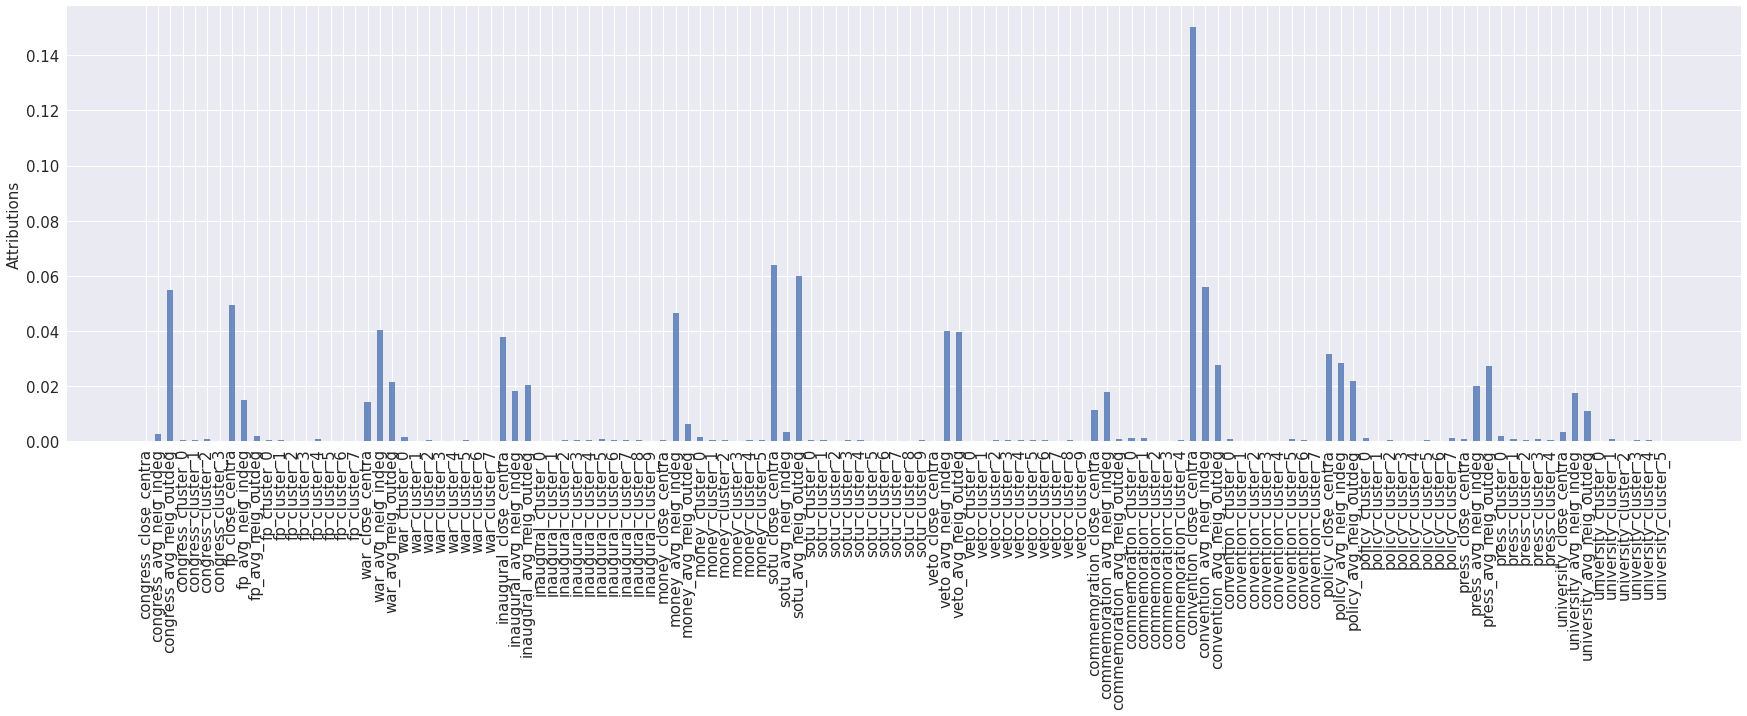

In [36]:
x_axis_data = np.arange(train_dl.dataset.dataset.X.shape[1])
x_axis_data_labels = list(map(lambda idx: CSVDataset(path).features[idx], x_axis_data))
plt.style.use(['seaborn'])
plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(30, 8))
ax = plt.subplot()
ax.set_ylabel('Attributions', fontsize=15)
ax.bar(x_axis_data, abs(ig_attr_test_norm_sum), 0.5, align='center', alpha=0.8)
plt.xticks(x_axis_data, x_axis_data_labels, rotation = 90)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [ ]:
len(x_axis_data_labels)

80